In [42]:
#import libraries
import numpy as np 
import pandas as pd
import math 
import sys
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy.interpolate import lagrange

In [43]:
def entropy(y):
    prob = y.value_counts()/y.shape[0]
    entropy = np.sum(-prob*np.log2(prob)) #for prob not to be 0 in log
    return entropy

In [44]:
def info_gain(y, mask, func = entropy):
    a = sum(mask)
    b = mask.shape[0] - a
    if a == 0 or b == 0:
        return 0
    else:
        return func(y) - (func(y[mask])*a/(a+b) + func(y[-mask])*b/(a+b)) 


In [45]:
def info_gain_ratio(col, y, mask, func = info_gain):
    if entropy != 0:
        return func(y, mask)/entropy(mask)
    return None

In [46]:
def total_info_gain(x, y):
    options = x.sort_values().unique()
    res = []
    for value in options:
        mask = x >= value
        ig = info_gain_ratio(x, y, mask)
        res.append([value, ig])
    return res

In [47]:
columns_name = ['x1', 'x2', 'y']
df = pd.read_csv('data/Druns.txt', names = columns_name, sep = ' ')
colname = ['value', 'ig_ratio']
df1 = pd.DataFrame(total_info_gain(df["x1"], df["y"]))
print(df1)
df2 = pd.DataFrame(total_info_gain(df["x2"], df["y"]))
print(df2)


     0         1
0  0.0       NaN
1  0.1  0.100518
    0         1
0  -2       NaN
1  -1  0.100518
2   0  0.055954
3   1  0.005780
4   2  0.001144
5   3  0.016411
6   4  0.049749
7   5  0.111240
8   6  0.236100
9   7  0.055954
10  8  0.430157


<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


In [48]:
colname_d3 = ['x1', 'x2', 'y']
df_d3 = pd.read_csv('data/D3leaves.txt', names= colname_d3, sep = ' ')
print(df_d3)

   x1  x2  y
0  10   1  1
1  10   2  1
2  10   3  1
3   1   1  0
4   1   3  1


In [49]:
def max_info_gain(x, y, func = entropy):
    options = x.sort_values().unique()
    res = -1
    split_value = -1000
    num = 0
    for value in options:
        mask = x >= value
        ig = info_gain_ratio(x, y, mask)
        if ig is not None and ig > res: 
            res = ig
            split_value = value
            num = num + 1
            #new 
            entro = entropy(mask)
    if num == 0 or res == -1:
        return (None, None, None, False)
    else: 
        return(split_value, res, entro, True)

In [50]:
columns_name = ['x1', 'x2', 'y']
df = pd.read_csv('data/Druns.txt', names = columns_name, sep = ' ')
cu = df.drop('y', axis = 1).apply(max_info_gain, y = df['y'])
cu

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


,x1,x2
0,0.1,8
1,0.100518,0.430157
2,0.439497,0.439497
3,True,True


In [51]:
cu.loc[3,:]

x1    True
x2    True
Name: 3, dtype: object

In [52]:
cu = cu.loc[:, cu.loc[3,:]]
cu = cu.apply(pd.to_numeric)

In [53]:
cu

,x1,x2
0,0.100000,8.000000
1,0.100518,0.430157
2,0.439497,0.439497
3,1.000000,1.000000


In [54]:
cu['Max'] = cu.idxmax(axis = 1)

In [55]:
cu

,x1,x2,Max
0,0.100000,8.000000,x2
1,0.100518,0.430157,x2
2,0.439497,0.439497,x1
3,1.000000,1.000000,x1


In [56]:
def get_best_split(x, out):
    try:
        masks = x.drop(out, axis = 1).apply(max_info_gain, y = x[out])
        if masks is None or len(masks) == 0 or np.sum(masks.loc[3, :]) == 0:
            return (None, None, False, None)
        else:
            masks = masks.loc[:, masks.loc[3,:]]
            masks = masks.apply(pd.to_numeric)
            temporary = masks.idxmin(axis = 1)[2] #column name of the lowest entropy
            #temporary2 = np.sum(masks.loc[2, :])
            #if temporary2 == 0: #box has the lowest entropy
            #    return (None, None, False, 0)
            if masks[temporary][2]  < 0.001: #new
                #return (None, None, False)
                check = 1 #there is entropy == 0 #new
                masks = masks.loc[:, masks.loc[2, :] == 0] #new, choose columns has entropy = 0 to split
            else:
                check = 0 #there is no entropy == 0 #new
            masks['Max'] = masks.idxmax(axis = 1)
            split_vari = masks.loc[1][-1]
            split_value = masks[split_vari][0]
            split_ig = masks[split_vari][1]
        return(split_vari, split_value, split_ig, check)
    except KeyError:
        return (None, None, False, None)

In [57]:
test = pd.read_csv('data/2.2.txt', names= ['x1', 'x2', 'y'], sep = ' ')
masks = test.drop('y', axis = 1).apply(max_info_gain, y = test['y'])
masks

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


,x1,x2
0,None,2
1,None,0.0
2,None,0.591673
3,False,True


In [58]:
get_best_split(test, 'y')

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


('x2', 2.0, 0.0, 0)

In [59]:
def make_split(vari, value, data):
    data1 = data[data[vari] >= value]
    data2 = data[data[vari] < value]
    return data1, data2

In [60]:
make_split('x1', 5.0, test)

(   x1  x2  y
 0   5   1  1
 1   5   2  1
 2   5   3  1
 3   5   4  1
 4   5   5  1
 5   5   6  1
 6   5   7  1,
 Empty DataFrame
 Columns: [x1, x2, y]
 Index: [])

In [61]:
def make_pred(data):
    return data.value_counts().idxmax()

In [62]:
def train_tree(data, y, max_depth = None, counter = 0):
    var, val, ig, check = get_best_split(data, y)
    if max_depth != None and counter >= max_depth:
        return make_pred(data[y])
    if ig is not None and ig != 0 and len(data) != 0:
        counter = counter + 1
        left, right = make_split(var, val, data)
        split_type = ">="
        question = "{} {}  {}".format(var, split_type, val)
        subtree = {question: []}
        if check == 1: #new
            a = make_pred(left[y]) #new
            b = make_pred(right[y]) #new
            subtree[question].append(a) #new
            subtree[question].append(b) #new
            return subtree 
        yes_ans = train_tree(left, y, max_depth, counter) 
        no_ans = train_tree(right, y, max_depth, counter)
        if yes_ans == no_ans:
            subtree = yes_ans #new subtree
        else:
            subtree[question].append(yes_ans)
            subtree[question].append(no_ans)
    else:
        return make_pred(data[y])
    return subtree

In [63]:
def classi_pred(observaction, side):
    quest_key = next(iter(side.keys())) #get the first key, or the first question
    vari = quest_key.split()[0] #choose what variables to compare
    if isinstance(observaction, pd.Series):
        if observaction[vari] >= float(quest_key.split()[2]):
            answer = side[quest_key][0]
        else:
            answer = side[quest_key][1]
    if isinstance(observaction, list):
        if vari == 'x1':
            index = 0
        else:
            index = 1
        if observaction[index] >= float(quest_key.split()[2]):
            answer = side[quest_key][0]
        else:
            answer = side[quest_key][1]
    #base case: if the answer is not a dict
    if not isinstance(answer, dict):
        return answer
    else:
        return classi_pred(observaction, answer) #go to the side of condition

In [64]:
d3_tree = train_tree(df_d3, 'y')

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

In [65]:
d3_tree

{'x1 >=  10.0': [1, {'x2 >=  3': [1, 0]}]}

In [66]:
df_d1 = pd.read_csv('data/D1.txt', names = colname_d3, sep = " ")
d1_tree = train_tree(df_d1,'y')
d1_tree

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  0.201829': [1, 0]}

In [67]:
df_d2 = pd.read_csv('data/D2.txt', names = colname_d3, sep = " ")
question_d2 = train_tree(df_d2,'y')

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

In [68]:
question_d2

{'x1 >=  0.533076': [{'x2 >=  0.228007': [{'x2 >=  0.424906': [1,
      {'x1 >=  0.708127': [1,
        {'x2 >=  0.32625': [{'x1 >=  0.595471': [{'x1 >=  0.646007': [1,
              {'x2 >=  0.403494': [1, 0]}]},
            0]},
          0]}]}]},
    {'x1 >=  0.887224': [{'x2 >=  0.037708': [{'x2 >=  0.082895': [1,
          {'x1 >=  0.960783': [1, 0]}]},
        0]},
      {'x1 >=  0.850316': [{'x2 >=  0.169053': [1, 0]}, 0]}]}]},
  {'x2 >=  0.88635': [{'x1 >=  0.041245': [{'x1 >=  0.104043': [1,
        {'x1 >=  0.07642': [0, 1]}]},
      0]},
    {'x2 >=  0.691474': [{'x1 >=  0.254049': [1,
        {'x1 >=  0.191915': [{'x2 >=  0.792752': [1, 0]},
          {'x2 >=  0.864128': [{'x1 >=  0.144781': [1, 0]}, 0]}]}]},
      {'x2 >=  0.534979': [{'x1 >=  0.426073': [1,
          {'x1 >=  0.409972': [{'x1 >=  0.417579': [0, 1]},
            {'x1 >=  0.393227': [{'x1 >=  0.39583': [0, 1]}, 0]}]}]},
        0]}]}]}]}

In [69]:
pred_d2 = []
for i in range(df_d2.shape[0]):
    data_pred = classi_pred(df_d2.iloc[i,:], question_d2)
    pred_d2.append(data_pred)
actual_d2 = df_d2.y.tolist()
truth_d2= np.subtract(actual_d2, pred_d2)
accuracy = 1 - np.count_nonzero(truth_d2)/len(truth_d2)
accuracy

1.0

In [70]:
df_d2.y

0      1
1      1
2      1
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    1
Name: y, Length: 1000, dtype: int64

In [71]:
next(iter(question_d2.keys()))

'x1 >=  0.533076'

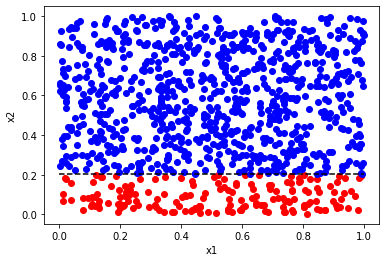

In [72]:
fig, ax = plt.subplots()

for label in [0,1]:
    #filters this sequence of indices by keeping only those where df_d1['y'][i] is equal to label, go first with label 0
    row_ix = [i for i in range(len(df_d1['y'])) if df_d1['y'][i] == label] 
    plt.scatter([df_d1['x1'][i] for i in row_ix], [df_d1['x2'][i] for i in row_ix], c= ['red' if label == 0 else 'blue'])

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.hlines(y= 0.201829, xmin = 0, xmax = 1, linestyles= '--', colors= 'black')
plt.show()

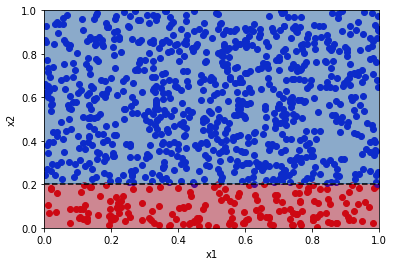

In [73]:
fig, ax = plt.subplots()

for label in [0,1]:
    #filters this sequence of indices by keeping only those where df_d1['y'][i] is equal to label, go first with label 0
    row_ix = [i for i in range(len(df_d1['y'])) if df_d1['y'][i] == label] 
    plt.scatter([df_d1['x1'][i] for i in row_ix], [df_d1['x2'][i] for i in row_ix], c= ['red' if label == 0 else 'blue'])

x1 = np.linspace(0, 1, 3000)
x2 = np.linspace(0, 1, 3000)
#takes two 1-D arrays as inputs and
# returns two 2-D arrays representing all possible combinations of their elements.
x1_grid1, x2_grid1 = np.meshgrid(x1, x2)
z = np.zeros_like(x1_grid1)
for i in range(x1_grid1.shape[0]):
    for j in range(x1_grid1.shape[1]):
        z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], d1_tree)
plt.contourf(x1_grid1, x2_grid1, z, cmap='RdBu', alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.hlines(y= 0.201829, xmin = 0, xmax = 1, linestyles= '--', colors= 'black')
plt.show()

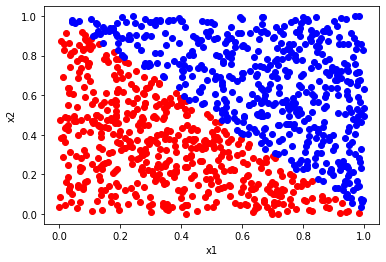

In [74]:
fig, ax = plt.subplots()

for label in [0,1]:
    row_ind = [i for i in range (len(df_d2['y'])) if df_d2['y'][i] == label]
    plt.scatter([df_d2['x1'][row_ind]], [df_d2['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

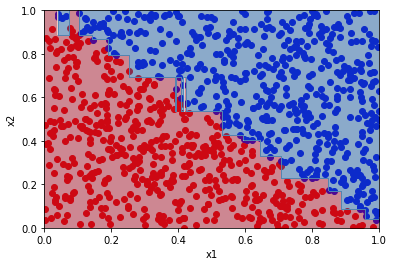

In [75]:
fig, ax = plt.subplots()

for label in [0,1]:
    row_ind = [i for i in range (len(df_d2['y'])) if df_d2['y'][i] == label]
    plt.scatter([df_d2['x1'][row_ind]], [df_d2['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
x1 = np.linspace(0, 1, 3000)
x2 = np.linspace(0, 1, 3000)
#takes two 1-D arrays as inputs and
# returns two 2-D arrays representing all possible combinations of their elements.
x1_grid1, x2_grid1 = np.meshgrid(x1, x2)
z = np.zeros_like(x1_grid1)
for i in range(x1_grid1.shape[0]):
    for j in range(x1_grid1.shape[1]):
        z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], question_d2)
plt.contourf(x1_grid1, x2_grid1, z, cmap='RdBu', alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

In [76]:
colname_d3 = ['x1', 'x2', 'y']
dbig = pd.read_csv('data/Dbig.txt', sep= " ", names= colname_d3)

np.random.seed(0)
ind_list = np.random.permutation(10000) #list of 10000 numbers in random numbers

training_ind = ind_list[:8192]
test_ind = ind_list[8192:]
train_set = dbig.loc[training_ind]
test_set = dbig.loc[test_ind]
dbig

,x1,x2,y
0,-1.499372,0.976384,1
1,-1.499224,-0.517983,1
2,-1.498880,-1.271624,1
3,-1.498383,1.456647,1
4,-1.498293,-1.290862,1
...,...,...,...
9995,1.498964,0.036682,1
9996,1.499012,1.444314,1
9997,1.499284,0.447541,1
9998,1.499313,1.092598,1


In [77]:
tree_8192 = train_tree(train_set, 'y')
train_set = train_set.reset_index()

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

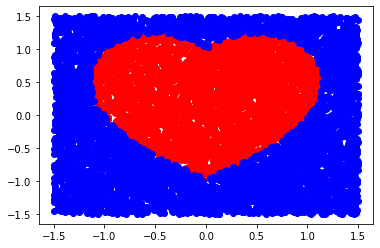

In [78]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)

for label in [0,1]:
    row_ind = [i for i in range (len(train_set['y'])) if train_set['y'][i] == label]
    plt.scatter([train_set['x1'][row_ind]], [train_set['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    

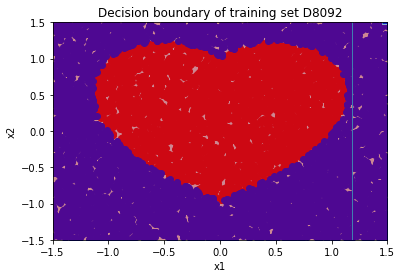

In [79]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)    

# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
         z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], tree_8192)

for label in [0,1]:
    row_ind = [i for i in range (len(train_set['y'])) if train_set['y'][i] == label]
    plt.scatter([train_set['x1'][row_ind]], [train_set['x2'][row_ind]], c = 'red' if label == 0 else 'blue')

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D8092')
plt.show()

In [80]:
training_ind_32 = ind_list[:32]
test_ind_32 = ind_list[32:]
train_set32 = dbig.loc[training_ind_32]
test_set32 = dbig.loc[test_ind_32]
tree_32 = train_tree(train_set32, 'y')


<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

In [81]:
train_set32 = train_set32.reset_index()

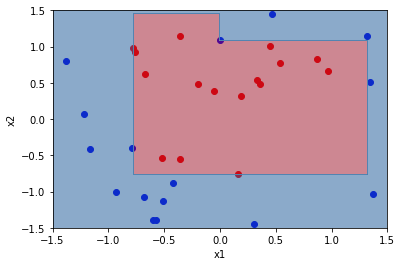

In [82]:
fig, ax = plt.subplots()

for label in [0,1]:
    row_ind = [i for i in range (len(train_set32['y'])) if train_set32['y'][i] == label]
    plt.scatter([train_set32['x1'][row_ind]], [train_set32['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
     
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
#takes two 1-D arrays as inputs and
# returns two 2-D arrays representing all possible combinations of their elements.
x1_grid1, x2_grid1 = np.meshgrid(x1, x2)
z = np.zeros_like(x1_grid1)
for i in range(x1_grid1.shape[0]):
    for j in range(x1_grid1.shape[1]):
        z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], tree_32)
plt.contourf(x1_grid1, x2_grid1, z, cmap='RdBu', alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

In [83]:
training_ind_128 = ind_list[:128]
test_ind_128 = ind_list[128:]
train_set128 = dbig.loc[training_ind_128]
test_set128 = dbig.loc[test_ind_128]
tree_128 = train_tree(train_set128, 'y')
train_set128 = train_set128.reset_index()

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

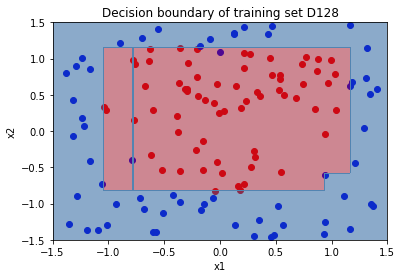

In [84]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set128['y'])) if train_set128['y'][i] == label]
    plt.scatter([train_set128['x1'][row_ind]], [train_set128['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
         z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], tree_128)

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D128')
plt.show()

In [85]:
training_ind_512 = ind_list[:512]
test_ind_512 = ind_list[512:]
train_set512 = dbig.loc[training_ind_512]
test_set512 = dbig.loc[test_ind_512]
tree_512 = train_tree(train_set512, 'y')
train_set512 = train_set512.reset_index()

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

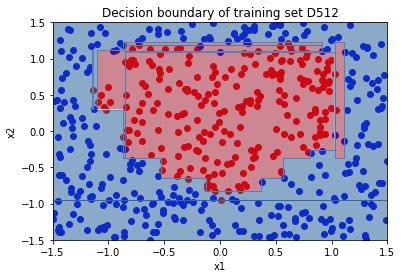

In [86]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set512['y'])) if train_set512['y'][i] == label]
    plt.scatter([train_set512['x1'][row_ind]], [train_set512['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
         z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], tree_512)

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D512')
plt.show()

In [87]:
training_ind_2048 = ind_list[:2048]
test_ind_2048 = ind_list[2048:]
train_set2048 = dbig.loc[training_ind_2048]
test_set2048 = dbig.loc[test_ind_2048]
tree_2048 = train_tree(train_set2048, 'y')
train_set2048 = train_set2048.reset_index()

<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
<ipython-input-45-4ef3c9c7f65a>:3: RuntimeWarning: invalid value encountered

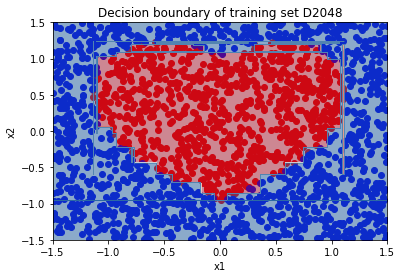

In [88]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set2048['y'])) if train_set2048['y'][i] == label]
    plt.scatter([train_set2048['x1'][row_ind]], [train_set2048['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
         z[i, j] = classi_pred([float(x1_grid1[i, j]), float(x2_grid1[i, j])], tree_2048)

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D2048')
plt.show()

In [89]:
test_set32 = test_set32.reset_index()
test_set128 = test_set128.reset_index()
test_set512 = test_set512.reset_index()
test_set2048 = test_set2048.reset_index()

In [90]:
test_set = test_set.reset_index()

In [91]:
err = []

In [92]:
pred_d32 = []
for i in range(test_set32.shape[0]):
    data_pred = classi_pred(test_set32.iloc[i,:], tree_32)
    pred_d32.append(data_pred)
actual_d32 = test_set32.y.tolist()
truth_d32= np.subtract(actual_d32, pred_d32)
accuracy_32 = np.count_nonzero(truth_d32)/len(truth_d32)
err.append([accuracy_32, 6])
accuracy_32

0.17215088282504012

In [93]:
test_set32

,index,x1,x2,y
0,4795,-0.028236,-0.420243,0
1,4747,-0.043642,-0.823998,0
2,9366,1.311598,0.735445,1
3,5334,0.134161,-1.289224,1
4,6652,0.524710,0.562768,0
...,...,...,...,...
9963,9225,1.266343,0.547834,1
9964,4859,-0.010735,-0.852709,0
9965,3264,-0.496923,-1.401295,1
9966,9845,1.456000,0.069382,1


In [94]:
pred_d128 = []
for i in range(test_set128.shape[0]):
    data_pred = classi_pred(test_set128.iloc[i,:], tree_128)
    pred_d128.append(data_pred)
actual_d128 = test_set128.y.tolist()
truth_d128= np.subtract(actual_d128, pred_d128)
accuracy_128 = np.count_nonzero(truth_d128)/len(truth_d128)
err.append([accuracy_128, 9])
accuracy_128

0.11142625607779579

In [95]:
pred_d512 = []
for i in range(test_set512.shape[0]):
    data_pred = classi_pred(test_set512.iloc[i,:], tree_512)
    pred_d512.append(data_pred)
actual_d512 = test_set512.y.tolist()
truth_d512= np.subtract(actual_d512, pred_d512)
accuracy_d512 = np.count_nonzero(truth_d512)/len(truth_d512)
err.append([accuracy_d512, 28])
accuracy_d512

0.05459527824620573

In [96]:
pred_d2048 = []
for i in range(test_set2048.shape[0]):
    data_pred = classi_pred(test_set2048.iloc[i,:], tree_2048)
    pred_d2048.append(data_pred)
actual_d2048 = test_set2048.y.tolist()
truth_d2048= np.subtract(actual_d2048, pred_d2048)
accuracy_d2048 = np.count_nonzero(truth_d2048)/len(truth_d2048)
err.append([accuracy_d2048, 59])
accuracy_d2048

0.03005533199195171

In [97]:
pred = []
for i in range(test_set.shape[0]):
    data_pred = classi_pred(test_set.iloc[i,:], tree_8192)
    pred.append(data_pred)
actual = test_set.y.tolist()
truth= np.subtract(actual, pred)
accuracy = np.count_nonzero(truth)/len(truth)
err.append([accuracy, 136])
accuracy

0.012168141592920354

In [98]:
test_set.iloc[1,:]

index    6306.000000
x1          0.420233
x2         -0.957071
y           1.000000
Name: 1, dtype: float64

In [99]:
err

[[0.17215088282504012, 6],
 [0.11142625607779579, 9],
 [0.05459527824620573, 28],
 [0.03005533199195171, 59],
 [0.012168141592920354, 136]]

<AxesSubplot:xlabel='number of node', ylabel='test set error'>

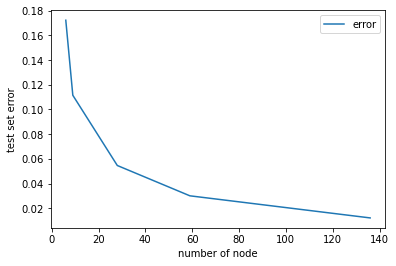

In [100]:
pd.DataFrame(err, columns= ['error','n']).plot.line(x = 'n', y = 'error', xlabel = 'number of node', ylabel = 'test set error')

Sklearn.tree

<AxesSubplot:xlabel='number of node', ylabel='test error'>

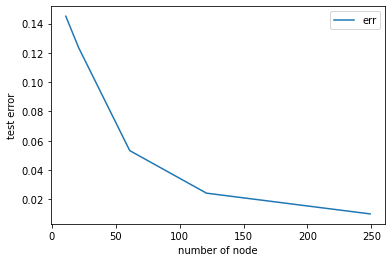

In [101]:
list_tree = []
clf32 = DecisionTreeClassifier()
clf32 = clf32.fit(train_set32.drop('y', axis = 1), train_set32['y'])
#use score() method of the fitted classifier object, passing in the training/test data
test_error32 = 1 - clf32.score(test_set32.drop('y', axis = 1), test_set32['y'])
list_tree.append([clf32.tree_.node_count, test_error32])

clf128 = DecisionTreeClassifier()
clf128 = clf128.fit(train_set128.drop('y', axis = 1), train_set128['y'])
test_error128 =  1 - clf128.score(test_set128.drop('y', axis = 1), test_set128['y'])
list_tree.append([clf128.tree_.node_count, test_error128])

clf512 = DecisionTreeClassifier()
clf512 = clf512.fit(train_set512.drop('y', axis = 1), train_set512['y'])
test_error512 =  1 - clf512.score(test_set512.drop('y', axis = 1), test_set512['y'])
list_tree.append([clf512.tree_.node_count, test_error512])

clf2048 = DecisionTreeClassifier()
clf2048 = clf2048.fit(train_set2048.drop('y', axis = 1), train_set2048['y'])
test_error2048 =  1 - clf2048.score(test_set2048.drop('y', axis = 1), test_set2048['y'])
list_tree.append([clf2048.tree_.node_count, test_error2048])

clf8092 = DecisionTreeClassifier()
clf8092 = clf8092.fit(train_set.drop('y', axis = 1), train_set['y'])
test_error8092 =  1 - clf8092.score(test_set.drop('y', axis = 1), test_set['y'])
list_tree.append([clf8092.tree_.node_count, test_error8092])

pd.DataFrame(list_tree, columns= ['n', 'err']).plot.line(x = 'n', y = 'err', xlabel = 'number of node', ylabel = 'test error')



In [102]:
list_tree

[[11, 0.1450642054574639],
 [21, 0.1236831442463533],
 [61, 0.05322512647554811],
 [121, 0.024144869215291798],
 [249, 0.009955752212389424]]

Lagrange Interpolation

In [103]:
a,b, n = 0, np.pi, 100
list_cu = []

#train set
x_train = np.linspace(a, b, n)
y_train = np.sin(x_train)

#test set
x_test = np.linspace(a, b, 50)
y_test = np.sin(x_test)

f = lagrange(x_train,y_train)

#training error and test error 
train_error = np.mean((f(x_train) - y_train)**2)
test_error = np.mean((f(x_test) - y_test)**2)
list_cu.append([0, train_error, test_error])
for i in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    #train with noise set from 0 to 0.35
    np.random.seed(0)
    noise = np.random.normal(0, i, n)
    x_train_noise = x_train + noise
    y_train_noise = np.sin(x_train_noise)

    f_noise = lagrange(x_train_noise, y_train_noise)
    
    #train error & test error
    train_error = np.mean((f_noise(x_train_noise) - y_train_noise)**2)
    test_error = np.mean((f_noise(x_test) - y_test)**2)
    list_cu.append([i, train_error, test_error])

list_cu


[[0, 2.764987948841503e+139, 4.448900234046315e+139],
 [0.05, 2.5372300086359705e+146, 9.397726153150905e+145],
 [0.1, 1.8348342655720676e+150, 2.812304416389374e+148],
 [0.15, 1.0271350471838772e+152, 4.371386765257422e+147],
 [0.2, 2.0902736336674595e+153, 3.895983632576597e+147],
 [0.25, 1.1474712203801628e+156, 1.8219155307474113e+149],
 [0.3, 4.445414052031636e+155, 7.97238633803938e+147],
 [0.35, 1.820988310623467e+153, 7.771471652870264e+144]]